### Adversarial examples

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

5


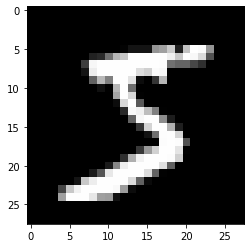

In [24]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_labels[0])
plt.imshow(train_images[0], cmap='Greys_r')

train_images = train_images.reshape([-1, 28, 28, 1])
train_images = train_images.astype(np.float32) / 255
test_images = test_images.reshape([-1, 28, 28, 1])
test_images = test_images.astype(np.float32) / 255
data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels.astype(np.int32))).batch(128)

In [25]:
model = tf.keras.Sequential(name="Model1")
model.add(tf.keras.layers.Conv2D(28, 3, activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(56, 3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10))
model.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 56)        14168     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 56)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               140100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010 

In [26]:
opt = tf.optimizers.Adam(0.01)

# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [27]:
model.compile(loss= loss_fn, optimizer= opt, metrics= ['accuracy'])
history = model.fit(data, batch_size=64, epochs=5, steps_per_epoch=500)

test_scores = model.evaluate(test_data, verbose= 2)

Epoch 1/5
500/500 [==============================] - 40s 79ms/step - loss: 0.1362 - accuracy: 0.9575
Epoch 2/5
500/500 [==============================] - 39s 79ms/step - loss: 0.0522 - accuracy: 0.9840
Epoch 3/5
500/500 [==============================] - 39s 79ms/step - loss: 0.0404 - accuracy: 0.9872
Epoch 4/5
500/500 [==============================] - 40s 79ms/step - loss: 0.0362 - accuracy: 0.9886
Epoch 5/5
500/500 [==============================] - 39s 78ms/step - loss: 0.0322 - accuracy: 0.9900
79/79 - 2s - loss: 0.0615 - accuracy: 0.9870


In [28]:
# test_scores = model.evaluate(test_data, verbose= 2)

In [29]:
model.predict_classes(test_data)

array([7, 2, 1, ..., 4, 5, 6])

Adversarial example dataset of 40000 samples is created using targeted attack. The examples are generated by random initialisation and updating the input according to the gradients obtained. The input updated is done as explained [here](https://ml.berkeley.edu/blog/posts/adversarial-examples/).

with tf.math.sign

In [30]:
adv_img = []
x_target = train_images[:40000]
x_target = x_target.reshape([-1, 28, 28, 1])
x_target = x_target.astype(np.float32) / 255

# x_tar_lbl = train_labels[7]
adv_lbl = []
                         
for i in range(40000):
  x = tf.Variable(tf.random.normal((28,28, 1), 0.5, 0.3))
  x_tar_lbl = np.random.randint(0,9)
  adv_img.append(x)
  adv_lbl.append(x_tar_lbl)

adv_img = tf.convert_to_tensor(adv_img)
# adv_img = tf.reshape(adv_img, [-1, 28, 28, 1])

print(tf.shape(adv_img))
# adv_data = tf.data.Dataset.from_tensor_slices(
#     (adv_img, adv_lbl)).batch(128)

tf.Tensor([40000    28    28     1], shape=(4,), dtype=int32)


In [31]:
lr = 1.5
lmbda = 0.05

@tf.function
def grd(adv_img, adv_lbl):
  with tf.GradientTape() as t:
    t.watch(adv_img)
    logits = model(adv_img)
    xent = loss_fn(adv_lbl, logits)

  grads = t.gradient(xent, adv_img)
  grad_sign = tf.math.sign(grads)
  return grad_sign  

for i in range(100):
  # with tf.GradientTape() as t:
  #   t.watch(adv_img)
  #   logits = model(adv_img)
  #   xent = loss_fn(adv_lbl, logits)
  # grads = t.gradient(xent, adv_img)
  # grad_sign = tf.math.sign(grads)
  grads_sign = grd(adv_img, adv_lbl)
  grad_sign = grads_sign.numpy()
  adv_img = adv_img - (lr * (grad_sign + lmbda * (adv_img - x_target)))
  # adv_img = test_images + adv_img

Text(0.5, 1.0, 'Adverserial')

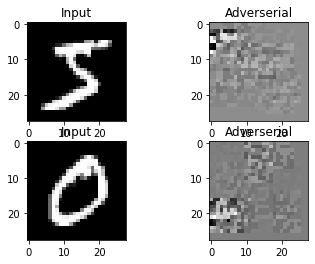

In [32]:
test_image = tf.reshape(train_images[0], [28, 28])
adv_image = tf.reshape(adv_img[0], [28, 28])

test_image1 = tf.reshape(train_images[1], [28, 28])
adv_image1 = tf.reshape(adv_img[1], [28, 28])
# plt.imshow(adv_image, cmap='Greys_r')

input = plt.subplot(2,2, 1)
plt.imshow(test_image, cmap='Greys_r')
input.set_title('Input')

advs = plt.subplot(2, 2, 2)
plt.imshow(adv_image, cmap='Greys_r')
advs.set_title('Adverserial')

input = plt.subplot(2,2, 3)
plt.imshow(test_image1, cmap='Greys_r')
input.set_title('Input')

advs = plt.subplot(2, 2, 4)
plt.imshow(adv_image1, cmap='Greys_r')
advs.set_title('Adverserial')

In [33]:
adv_data = tf.data.Dataset.from_tensor_slices(
    (adv_img, adv_lbl)).batch(128)

model.evaluate(adv_data)
model.predict_classes(adv_data)

313/313 [==============================] - 8s 26ms/step - loss: 2.3520 - accuracy: 0.6032


array([8, 1, 8, ..., 1, 7, 3])

without tf.math.sign

In [ ]:
adv_img = []
x_target = train_images[:40000]
x_target = x_target.reshape([-1, 28, 28, 1])
x_target = x_target.astype(np.float32) / 255

# x_tar_lbl = train_labels[7]
adv_lbl = []
                         
for i in range(40000):
  x = tf.Variable(tf.random.normal((28,28, 1), 0.5, 0.3))
  x_tar_lbl = np.random.randint(0,9)
  adv_img.append(x)
  adv_lbl.append(x_tar_lbl)

adv_img = tf.convert_to_tensor(adv_img)
# adv_img = tf.reshape(adv_img, [-1, 28, 28, 1])

print(tf.shape(adv_img))
# adv_data = tf.data.Dataset.from_tensor_slices(
#     (adv_img, adv_lbl)).batch(128)

In [34]:
lr = 1.5
lmbda = 0.05

@tf.function
def grd(adv_img, adv_lbl):
  with tf.GradientTape() as t:
    t.watch(adv_img)
    logits = model(adv_img)
    xent = loss_fn(adv_lbl, logits)
  grads = t.gradient(xent, adv_img)
  # grad_sign = tf.math.sign(grads)
  return grads 

for i in range(100):
  # with tf.GradientTape() as t:
  #   t.watch(adv_img)
  #   logits = model(adv_img)
  #   xent = loss_fn(adv_lbl, logits)
  # grads = t.gradient(xent, adv_img)
  # grad_sign = tf.math.sign(grads)
  grads = grd(adv_img, adv_lbl)
  grad = grads.numpy()
  adv_img = adv_img - (lr * (grad + lmbda * (adv_img - x_target)))
  # adv_img = test_images + adv_img

Text(0.5, 1.0, 'Adverserial')

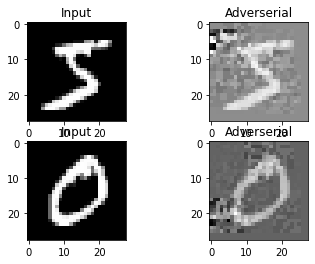

In [35]:
test_image = tf.reshape(train_images[0], [28, 28])
adv_image = tf.reshape(adv_img[0], [28, 28])

test_image1 = tf.reshape(train_images[1], [28, 28])
adv_image1 = tf.reshape(adv_img[1], [28, 28])
# plt.imshow(adv_image, cmap='Greys_r')

input = plt.subplot(2,2, 1)
plt.imshow(test_image, cmap='Greys_r')
input.set_title('Input')

advs = plt.subplot(2, 2, 2)
plt.imshow(adv_image, cmap='Greys_r')
advs.set_title('Adverserial')

input = plt.subplot(2,2, 3)
plt.imshow(test_image1, cmap='Greys_r')
input.set_title('Input')

advs = plt.subplot(2, 2, 4)
plt.imshow(adv_image1, cmap='Greys_r')
advs.set_title('Adverserial')

In [36]:
adv_data = tf.data.Dataset.from_tensor_slices(
    (adv_img, adv_lbl)).batch(128)

model.evaluate(adv_data)
model.predict_classes(adv_data)

313/313 [==============================] - 8s 26ms/step - loss: 2.4044 - accuracy: 0.1132


array([1, 1, 1, ..., 1, 1, 1])

In [37]:
model.compile(loss= loss_fn, optimizer= opt, metrics= ['accuracy'])
history = model.fit(adv_data, batch_size=64, epochs=5, steps_per_epoch=100)

# test_scores = model.evaluate(test_data, verbose= 2)

Epoch 1/5
100/100 [==============================] - 8s 75ms/step - loss: 2.2179 - accuracy: 0.1128
Epoch 2/5
100/100 [==============================] - 8s 76ms/step - loss: 2.2027 - accuracy: 0.1086
Epoch 3/5
100/100 [==============================] - 8s 76ms/step - loss: 2.2020 - accuracy: 0.1072
Epoch 4/5
 13/100 [==>...........................] - 1s 71ms/step - loss: 2.2033 - accuracy: 0.1112
